In [1]:
%matplotlib inline
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('elo.csv', encoding = "ISO-8859-1")
dob = pd.read_csv('idanddob.csv', encoding = "ISO-8859-1")

In [3]:
dob = dob.drop(['id'], axis=1).rename(columns={'idlow': 'id'})

In [4]:
df = df.merge(dob, how='left', on=['id'])

In [5]:
df = df.dropna().drop_duplicates(['id', 'tour'])

In [6]:
df.head()

,team,position,id,tour,prizeusd,start,end,startelo,startglicko2mu,startglicko2phi,startglicko2rating,endelo,endglicko2mu,endglicko2phi,endglicko2rating,cog,name,dob
0,orangeesports,pos1,mushi,WCG Asian Championship 2012,6000,08/09/2012,09/09/2012,1030.177755,1609.568030,64.173409,1449.134507,1029.970821,1609.568030,64.173409,1449.134507,Malaysia,Chai Yee Fung,1990-11-27
1,orangeesports,pos2,kyxy,WCG Asian Championship 2012,6000,08/09/2012,09/09/2012,1030.177755,1609.568030,64.173409,1449.134507,1029.970821,1609.568030,64.173409,1449.134507,Malaysia,Lee Kong Yang,1991-05-26
3,orangeesports,pos4,xtinct,WCG Asian Championship 2012,6000,08/09/2012,09/09/2012,1030.177755,1609.568030,64.173409,1449.134507,1029.970821,1609.568030,64.173409,1449.134507,Malaysia,Joel Chan Zhan Leong,1988-10-16
4,orangeesports,pos5,winter,WCG Asian Championship 2012,6000,08/09/2012,09/09/2012,1030.177755,1609.568030,64.173409,1449.134507,1029.970821,1609.568030,64.173409,1449.134507,Malaysia,Chan Litt Binn,1989-08-21
40,evilgeniuses,pos1,fear,RaidCall Dota 2 League Season 1,10000,10/09/2012,18/11/2012,1127.178191,1739.804399,58.251412,1594.175869,1102.305540,1757.679651,45.318269,1644.383978,United States,Clinton Loomis,1988-02-19


In [7]:
df.position = pd.to_numeric(df.position.str[-1])

In [8]:
df = df.rename(columns={'cog': 'country','id': 'player','prizeusd': 'prize','startelo': 'startelo64','endelo': 'endelo64'}).reset_index()

In [9]:
df = df[['country','team','player','position','dob','tour','start','end','prize','startelo64','endelo64']]

In [10]:
#convert day to datetime type
df.start = pd.to_datetime(df.start, format='%d/%m/%Y')
df.end = pd.to_datetime(df.end, format='%d/%m/%Y')
df.dob = pd.to_datetime(df.dob)
df.dtypes

#elo gain from each tournament
df['delo'] = df.endelo64 - df.startelo64

#cumulative sum of delo
cumsums = df[['player', 'start', 'delo']].groupby(['player', 'start']).sum().groupby(level=0).cumsum()
df = df.set_index(['player', 'start'])
df['rating'] = cumsums
df = df.reset_index()

#calculate age in year
df['age'] = (df.start - df.dob) / pd.Timedelta(days=365.25)

#experience
for player in df.player.unique():
    try:
        dfid = pd.DataFrame(df[df['player'] == player].sort_values('start').tour.unique()).reset_index().rename(columns={'index': 'exp', 0: 'tour'})
        dfid['player'] = player
        dfid2 = pd.concat([dfid2, dfid])
    except NameError:
        dfid2 = dfid
        continue

df = pd.merge(df, dfid2, how='left', on=['player', 'tour'])

#init is rating + initial mmr (assume first team = player's calibration)
init = df[df['startelo64'].notnull()].sort_values('start')[['startelo64', 'player']].groupby('player').first().reset_index().rename(columns={'startelo64': 'init'})
df = pd.merge(df, init, how='left', on='player')
df.init = df.rating + df.init

In [11]:
df = df.drop_duplicates(['player', 'tour'])

In [12]:
df.sample(5)

,player,start,country,team,position,dob,tour,end,prize,startelo64,endelo64,delo,rating,age,exp,init
292,loda,2013-03-14,Sweden,alliance,1,1988-03-19,DreamHack Dota 2 Invitational,2013-04-18,6000,1386.123794,1217.146973,-168.976821,310.411923,24.985626,2,1424.051321
2493,dkphobos,2015-03-20,Ukraine,natusvincere,3,1989-08-27,Major All Stars Dota 2 Tournament,2015-03-22,111979,1087.628141,1079.566043,-8.062097,-78.303805,25.560575,3,1127.974277
3075,jeyo,2015-10-03,Canada,teamarchon,1,1993-04-19,ESL One New York 2015,2015-10-04,286622,961.163077,961.429387,0.266310,-985.598828,22.455852,27,141.579363
73,scandal,2012-11-13,Russia,teamempire,2,1991-12-04,StarLadder StarSeries Season 4,2012-12-23,15000,1091.094696,1149.686258,58.591562,-40.349648,20.944559,1,1217.757723
2267,egm,2014-12-10,Sweden,alliance,4,1991-06-04,Esportal Dota 2 League Invitational Tournament 1,2014-12-14,18691.472328,1051.523771,1126.957696,75.433925,-531.585712,23.518138,31,582.053686


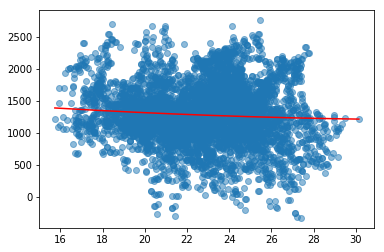

In [13]:
x = df['age']
y = df['init']
plt.scatter(x, y, alpha = 0.5)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 2))(np.unique(x)), 'r')

,init,tour,team,start
age,,,,
22.715948,1278.923707,StarLadder StarSeries Season 3,natusvincere,2012-09-17
22.757016,1385.715398,GosuLeague Season 4 Division 1,natusvincere,2012-10-02
22.841889,1382.721355,Electronic Sports World Cup 2012,natusvincere,2012-11-02
22.858316,1418.699031,GosuLeague Season 5 Division 1,natusvincere,2012-11-08
22.872005,1526.168874,StarLadder StarSeries Season 4,natusvincere,2012-11-13
22.896646,1445.277795,DreamHack Winter 2012,natusvincere,2012-11-22
22.907598,1455.928851,The Defense Season 3,natusvincere,2012-11-26
22.951403,1401.157146,RaidCall Dota 2 League Season 2,natusvincere,2012-12-12
22.954141,1396.945190,ASUS Open 2012 Finals,natusvincere,2012-12-13


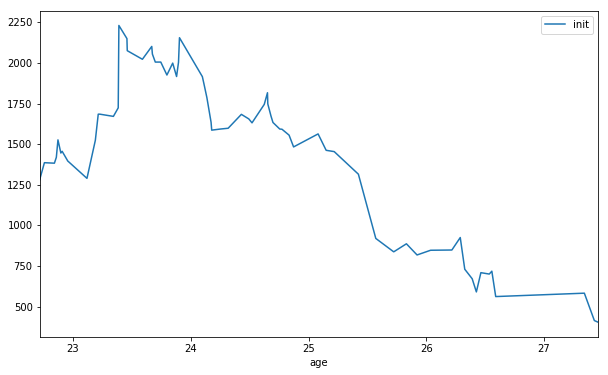

In [14]:
player = 'dendi'
fig = plt.figure(figsize=(10, 6))
ax = fig.gca()
df[df['player'] == player][['init', 'age']].set_index('age').sort_index().plot(ax=ax)
df[df['player'] == player][['init', 'tour', 'age', 'team', 'start']].set_index('age').sort_index()

In [16]:
df.describe()

,position,startelo64,endelo64,delo,rating,age,exp,init
count,5379.000000,5379.000000,5379.000000,5379.000000,5379.000000,5379.000000,5379.000000,5379.000000
mean,3.000372,1179.705342,1182.373370,2.668029,159.756802,22.634847,18.015988,1277.700053
std,1.417497,120.358190,130.601185,107.336807,463.098655,2.518540,15.722093,456.355204
min,1.000000,781.374292,785.673447,-371.313460,-1592.267845,15.739904,0.000000,-334.160473
25%,2.000000,1097.519834,1096.682438,-65.778321,-98.941210,20.898015,5.000000,1011.493419
50%,3.000000,1179.477810,1179.204323,-2.118967,128.493008,22.683094,14.000000,1241.572298
75%,4.000000,1257.719285,1267.229979,64.818335,456.710053,24.412047,27.000000,1561.612106
max,5.000000,1558.429071,1554.769362,392.011285,1613.977156,30.149213,76.000000,2755.198418


In [17]:
df.groupby('player').min()[['init']].sort_values('init', ascending=False)

,init
player,
sansheng,1471.842710
alohadance,1362.774799
noone,1346.476764
mason,1330.253033
hao,1321.661537
garter,1299.068862
byb,1299.018649
puppey,1278.923707
longdd,1268.990365
